In [4]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import datasets, pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### Generating the dummy dataset

In [5]:
# Generate dataset with 1000 samples, 100 features and 2 classes

def gen_dataset(n_samples=1000, n_features=100, n_classes=2, random_state=123):  
    X, y = datasets.make_classification(
        n_features=n_features,
        n_samples=n_samples,  
        n_informative=int(0.6 * n_features),    # the number of informative features
        n_redundant=int(0.1 * n_features),      # the number of redundant features
        n_classes=n_classes, 
        random_state=random_state)
    return (X, y)

X, y = gen_dataset(n_samples=1000, n_features=100, n_classes=2)

# Train / test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Setting up the GridSearch and Random Search parameter grid

In [6]:
pipe = pipeline.Pipeline([
    ('clf', lgb.LGBMClassifier())
    ])

param_gridsearch = {
    'clf__learning_rate' : [0.01, 0.1, 1],
    'clf__max_depth' : [5, 10, 15],
    'clf__n_estimators' : [5, 20, 35], 
    'clf__num_leaves' : [5, 25, 50],
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree' : [0.6, 0.75, 1],
    'clf__reg_lambda': [0.01, 0.1, 1],
}

param_random = {
    'clf__learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3)),
    'clf__max_depth': list(range(5, 15)),
    'clf__n_estimators': list(range(5, 35)),
    'clf__num_leaves': list(range(5, 50)),
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree': list(np.linspace(0.6, 1, 500)),
    'clf__reg_lambda': list(np.linspace(0, 1, 500)),
}

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

### GridSearch & Random Search function

In [7]:
def search(pipeline, parameters, X_train, y_train, X_test, y_test, optimizer='grid_search', n_iter=None):
    
    start = time.time() 
    
    if optimizer == 'grid_search':
        grid_obj = GridSearchCV(estimator=pipeline,
                                param_grid=parameters,
                                cv=5,
                                refit=True,
                                return_train_score=False,
                                scoring = 'accuracy',
                               )
        grid_obj.fit(X_train, y_train,)
    
    elif optimizer == 'random_search':
        grid_obj = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=parameters,
                            cv=5,
                            n_iter=n_iter,
                            refit=True,
                            return_train_score=False,
                            scoring = 'accuracy',
                            random_state=1)
        grid_obj.fit(X_train, y_train,)
    
    else:
        print('enter search method')
        return

    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, estimator

### GridSearch & Random Search (75 iterations)

In [9]:
num_eval =75
#results_grid, estimator_grid = search(pipe, param_gridsearch, X_train, y_train, X_test, y_test, 'grid_search')
results_random, estimator_random = search(pipe, param_random, X_train, y_train, X_test, y_test, 'random_search', num_eval)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
##### Results
Score best parameters:  0.8125
Best parameters:  {'clf__reg_lambda': 0.38476953907815625, 'clf__num_leaves': 39, 'clf__n_estimators': 34, 'clf__max_depth': 9, 'clf__learning_rate': 0.2298941543889502, 'clf__colsample_bytree': 0.9663326653306613, 'clf__boosting_type': 'dart'}
Cross-validation Score:  0.8125
Test Score:  0.85
Time elaps

### Hyperopt function

In [10]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

### Execute Hyperopt for 75 iterations

In [11]:
results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)

[LightGBM] [Warning]                                                              
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                 
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                 
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                 
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                 
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                              
Accuracy 

### Plot top validation scores over time for GridSearch and Random Search

In [12]:
# Retrieve Hyperopt scores

hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
hyperopt_scores = np.maximum.accumulate(hyperopt_scores)

# Retrieve Random Search scores

random_scores = np.maximum.accumulate(results_random['mean_test_score'])

[None, None, None, None]

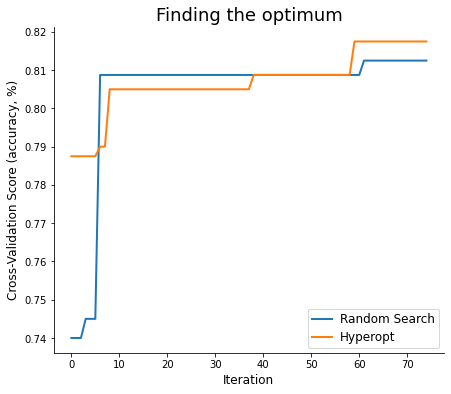

In [13]:
# Plot evaluation scores of each method over time

f, ax = plt.subplots(figsize=(7,6))
sns.set_palette("husl")
sns.despine()
ax = sns.lineplot(x=[x for x in range(num_eval)], y=random_scores, linewidth = 2)
ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
plt.title("Finding the optimum", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
plt.legend(loc='lower right', labels=['Random Search', 'Hyperopt'])
plt.setp(ax.get_legend().get_texts(), fontsize='12')

### Plot learning rate & num_leaves sampling distribution vs. distribution of values sampled by Hyperopt

In [14]:
# Randomly sample from learning rate and num_leaves distribution

learning_rate_space = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1))}
num_leaves_space = {'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1))}

learning_rate_dist = [sample(learning_rate_space)['learning_rate'] for x in range(1000)]
num_leaves_dist = [sample(num_leaves_space)['num_leaves'] for x in range(1000)]    

In [15]:
num_eval =500
results_random, estimator_random = search(pipe, param_random, X_train, y_train, X_test, y_test, 'random_search', num_eval)
results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning]                                                               
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                               
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                               
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                                
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                                                
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]             

In [16]:
# Retrieve learning rates and num_leaves' used by Hyperopt

learning_rate_hp = [trial['misc']['vals']['learning_rate'][0] for trial in results_hyperopt.trials]
num_leaves_hp = [trial['misc']['vals']['num_leaves'][0] for trial in results_hyperopt.trials]

[None, None, None, None]

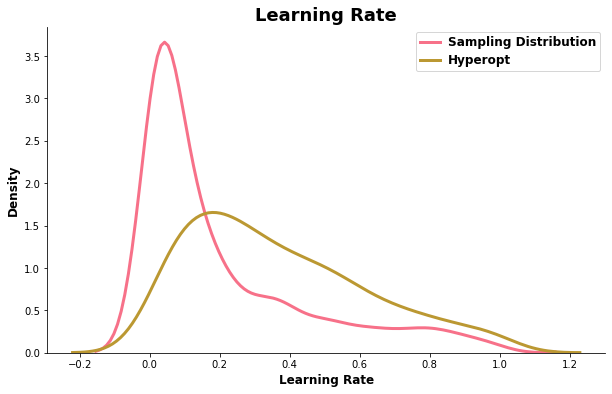

In [17]:
# Plot learning rate sampling distribution vs. values used by Hyperopt

f, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
sns.despine()
ax = sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 3)
ax = sns.kdeplot(learning_rate_hp, label = 'Hyperopt', linewidth = 3)
plt.title("Learning Rate", fontsize=18, fontweight='bold')
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold');
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')

[None, None, None, None]

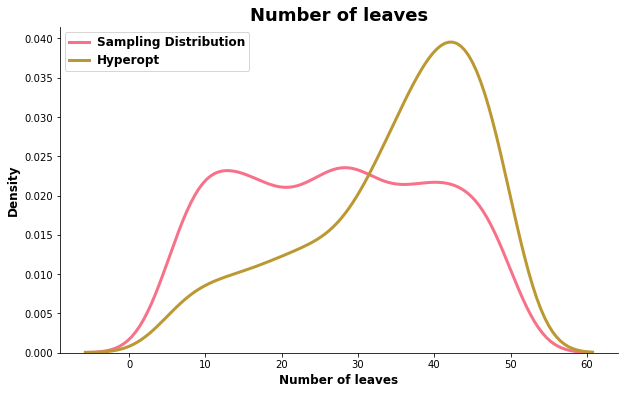

In [18]:
# Plot num_leaves sampling distribution vs. values used by Hyperopt

f, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
sns.despine()
ax = sns.kdeplot(num_leaves_dist, label = 'Sampling Distribution', linewidth = 3)
ax = sns.kdeplot(num_leaves_hp, label = 'Hyperopt', linewidth = 3)
plt.title("Number of leaves", fontsize=18, fontweight='bold')
plt.xlabel('Number of leaves', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')


Ref:
    
    * https://github.com/MBKraus/Hyperopt/blob/master/Hyperopt.ipynb